<a href="https://colab.research.google.com/github/Kazantsev-Alexey/ML_DS/blob/main/%D0%92%D1%8B%D1%8F%D0%B2%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B9_%D0%B0%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D1%81%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В представленном датасете находятся характеристики связанные с сетевым подключением. Задача: построить модель, которая будет отличать нормальную активность от подозрительной. Учитывая, что пропущенная подозрительная активность несет больше вреда, то и  основными метриками для оценки реузльтатов в данному случае является recall для значений атак в сети и presicion для нормальной активности.


Описание датасета находится здесь: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

Для начала загружаем библиотеки для работы с данными и сам датасет:



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as p
from sklearn.preprocessing import StandardScaler

In [ ]:
names=["duration","protocoltype","service","flag","srcbytes","dstbytes","land", 
        "wrongfragment","urgent","hot","numfailedlogins","loggedin", "numcompromised",
        "rootshell","suattempted","numroot","numfilecreations", "numshells","numaccessfiles",
        "numoutboundcmds","ishostlogin", "isguestlogin","count","srvcount","serrorrate", "srvserrorrate",
        "rerrorrate","srvrerrorrate","samesrvrate", "diffsrvrate", "srvdiffhostrate","dsthostcount",
        "dsthostsrvcount","dsthostsamesrvrate", "dsthostdiffsrvrate","dsthostsamesrcportrate",
        "dsthostsrvdiffhostrate","dsthostserrorrate","dsthostsrvserrorrate", "dsthostrerrorrate","dsthostsrvrerrorrate","attack", "lastflag"])

In [ ]:
df_train = pd.read_csv('/main/Train.csv', sep=',', header=0 , names=names)
df_test = pd.read_csv('/main/Test.csv', sep=',', header=0 , names=names)

In [ ]:
df_train.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   duration                125973 non-null  int64  
 1   protocoltype            125973 non-null  object 
 2   service                 125973 non-null  object 
 3   flag                    125973 non-null  object 
 4   srcbytes                125973 non-null  int64  
 5   dstbytes                125973 non-null  int64  
 6   land                    125973 non-null  int64  
 7   wrongfragment           125973 non-null  int64  
 8   urgent                  125973 non-null  int64  
 9   hot                     125973 non-null  int64  
 10  numfailedlogins         125973 non-null  int64  
 11  loggedin                125973 non-null  int64  
 12  numcompromised          125973 non-null  int64  
 13  rootshell               125973 non-null  int64  
 14  suattempted         

In [ ]:
df_train.describe()

,duration,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,lastflag
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


По нескольким столбцам наблюдаются значения среднего близкие к нулю. Если значения отличные от нуля носят характер выброса, то от подобных столбцов лучше будет избавиться.

Посмотрим какими значениями представлены стобцы и как проявляется корреляция c целевой переменной. Для этого потребуется перекодировать столбцы представленные строками.

In [ ]:
for i in df_train.describe():
  if df_train.describe()[i]['mean'] < 0.001:
    print(df_train[i].value_counts())

0    125948
1        25
Name: land, dtype: int64
0    125964
1         5
2         3
3         1
Name: urgent, dtype: int64
0    125926
1        42
2         5
Name: numshells, dtype: int64
0    125973
Name: numoutboundcmds, dtype: int64
0    125972
1         1
Name: ishostlogin, dtype: int64


In [ ]:
# переведем категориальные значения в числовые
def encoder(df):
    df_copy = df.copy() 
    enc_dict = {}
    for i in df_copy.columns:
        if df_copy.dtypes[i] == np.object:
            enc_dict[i] = p.LabelEncoder()
            df_copy[i] = enc_dict[i].fit_transform(df_copy[i]) 
    return df_copy, enc_dict

encoded_train, encoders_train = encoder(df_train) 
encoded_test, encoders_test = encoder(df_test) 

In [ ]:
for i in encoded_train:
  if i in ['land', 'urgent', 'numshells', 'numoutboundcmds', 'ishostlogin']:
    print(i, encoded_train['attack'].corr(encoded_train[i]))

land -0.01723898324061636
urgent -0.0035125317957662968
numshells 0.0007432878609525767
numoutboundcmds nan
ishostlogin 0.0004002918414059992


Удалим из перечисленных столбцов лишние. 

В данном случае есть смысл оставить только столбец land, остальные нам не понадобятся.

In [ ]:
for i in ['urgent', 'numshells', 'numoutboundcmds', 'ishostlogin']:
  del encoded_train[i]
  del encoded_test[i]

Теперь необходимо понимать в каком виде у нас представлена целевая переменная. Для этого посмотрим на соотношение видов активности.

In [ ]:
df_train['attack'].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64

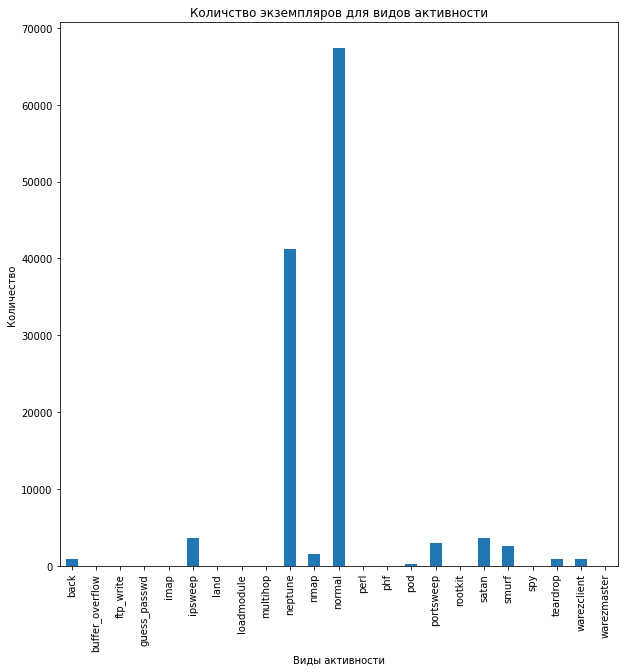

In [ ]:
df = df_train.groupby('attack').size()
df.plot(kind='bar', subplots=True, figsize=(10, 10), )
plt.title("Количство экземпляров для видов активности")
plt.ylabel("Количество")
plt.xlabel("Виды активности")
plt.show()

Так как некоторые виды представлены в количестве меньше десяти, то построить классификатор, для таких значений мы сможем наврядли. Поэтому самым оптимальным будет перевести переменную в бинарный формат:

In [ ]:
y_train = []  
for i in (df_train['attack']):
  if i == 'normal':
   y_train.append(0)
  else:
   y_train.append(1)
y_train = np.array(y_train)

y_test = []
for i in (df_test['attack']):
  if i == 'normal':
   y_test.append(0)
  else:
   y_test.append(1)
y_test = np.array(y_test)

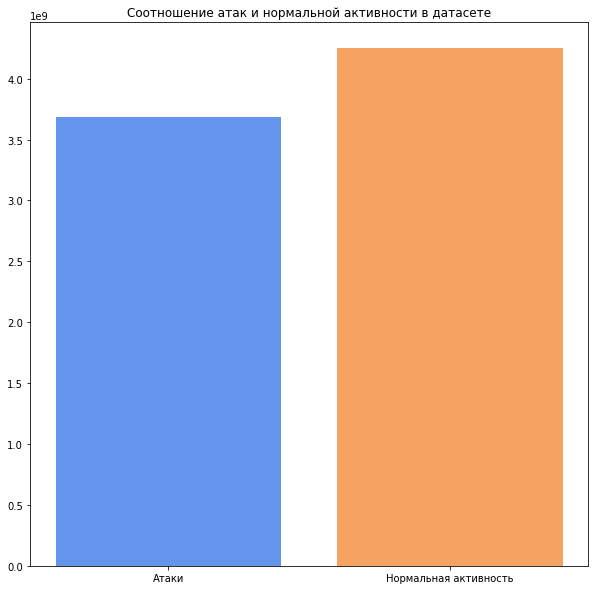

In [ ]:
attack = np.argwhere(y_train == 1).sum()
normal = np.argwhere(y_train == 0).sum()
x = ['Атаки', 'Нормальная активность']
y = [attack, normal]
fig, ax = plt.subplots(figsize=(10,10))
ax.bar(x, y, color=('cornflowerblue', 'sandybrown' ))
plt.title('Соотношение атак и нормальной активности в датасете')
plt.show()

In [ ]:
del encoded_train['attack']
del encoded_test['attack']

Теперь посмотрим на корреляцию в данных и выведем значения близкие к единице.

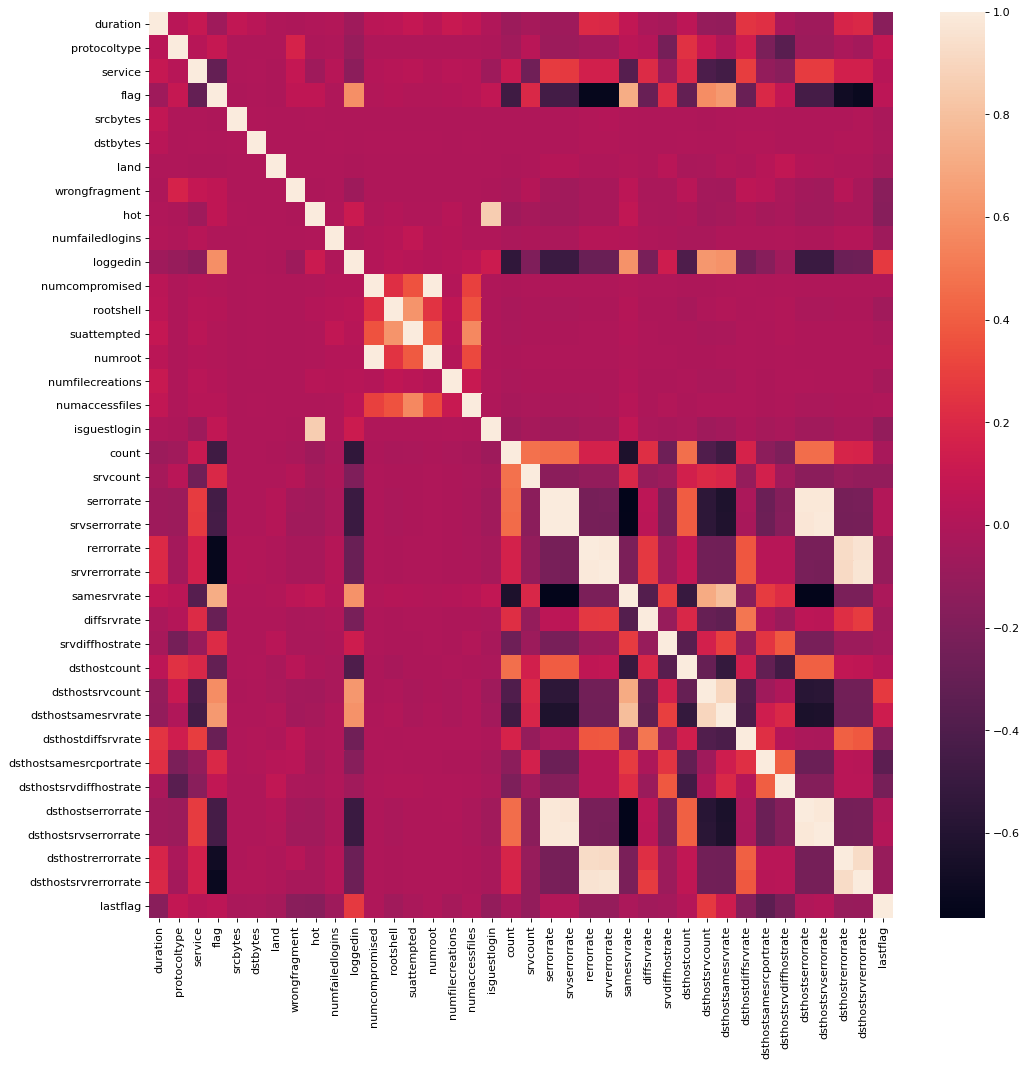

In [ ]:
import seaborn as sns 
plt.figure(figsize=(15,15), dpi=80)
heatmap = sns.heatmap(encoded_train.corr(), annot=False, )

In [ ]:
corr = encoded_train.corr()
count = 0
for i in list(corr):
  if str(i) != corr.index[corr[i] >= 0.9].tolist()[0]:
    print(str(i), corr.index[corr[i] >= 0.9].tolist()[0])
    count+=1
if count == 0:
  print('Единичные корреляции отсутствуют')

numroot numcompromised
srvserrorrate serrorrate
srvrerrorrate rerrorrate
dsthostserrorrate serrorrate
dsthostsrvserrorrate serrorrate
dsthostrerrorrate rerrorrate
dsthostsrvrerrorrate rerrorrate


Из описания датасета известно, что некоторые столбцы указывают на значения в столбце flag и частично дублируют друг друга. Сейчас очевидно, что это практически одни и теже значения. Удалим эти повторы:

In [ ]:
del encoded_train['serrorrate']
del encoded_train['rerrorrate']
del encoded_test['serrorrate']
del encoded_test['rerrorrate']

Теперь необходимо нормализовать данные для использования классическими моделями и перемешать их, чтобы исключить связь последовательности.

In [ ]:
from sklearn.utils import shuffle
X = np.array(encoded_train)
X_train = StandardScaler().fit(X).transform(X)
X1 = np.array(encoded_test)
X_test = StandardScaler().fit(X1).transform(X1)
X_train = shuffle(X_train, random_state = 42)
y_train = shuffle(y_train, random_state = 42)
print(X_test.shape, X_train.shape)

(22544, 36) (125973, 36)


Пока работа с датасетом закончена, теперь нужны библиотеки, для обучения моделей. 

In [ ]:
! pip install catboost

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import lightgbm as lgb
import multiprocessing
import time
import os


Построим модель на основе бэгинга и посмотрим какие характеристики модель определит как наиболее ценные. 

In [ ]:
start_time = time.time()
rfc = RandomForestClassifier(random_state=42)
param_gs = { 
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
gs = GridSearchCV(rfc, param_gs,  cv= 5)
gs.fit(X_train, y_train)
print(time.time() - start_time)

3597.220796585083


In [ ]:
best_p = gs.best_params_
rfc = RandomForestClassifier(random_state=42, n_estimators = best_p['n_estimators'],
          max_features = best_p['max_features'],
          max_depth = best_p['max_depth'],
          criterion = best_p['criterion'])
print(best_p)
rfc.fit(X_train, y_train)
print(rfc.feature_importances_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 150}
[1.93331582e-03 3.14089682e-02 1.81209815e-02 7.14493724e-02
 1.57685576e-01 1.41082543e-01 1.94707409e-05 2.02484149e-03
 5.50284890e-03 1.21273129e-04 3.11410942e-02 3.65605002e-03
 1.53874077e-05 8.05491832e-06 9.27935767e-05 1.47005292e-05
 5.17871203e-06 5.65805335e-04 3.97977844e-02 1.59018067e-02
 1.87020293e-02 2.45552764e-03 7.19775653e-02 6.94257761e-02
 3.68875672e-03 1.39046385e-02 7.70135830e-02 3.60500502e-02
 3.25303381e-02 2.12225240e-02 1.56636742e-02 1.77513762e-02
 1.81908794e-02 8.02058612e-03 7.26796631e-03 6.55868821e-02]


In [ ]:
print(metrics.classification_report(y_test, rfc.predict(X_test)))
print(metrics.roc_auc_score(y_test, rfc.predict(X_test)))
filename = '/content/drive/MyDrive/rfc.sav'
joblib.dump(rfc, filename)
for name, importance in zip(encoded_train.columns, rfc.feature_importances_):
  if importance>0.05:
    print(name, "=", importance)

              precision    recall  f1-score   support

           0       0.72      0.93      0.81      9711
           1       0.93      0.72      0.81     12833

    accuracy                           0.81     22544
   macro avg       0.82      0.82      0.81     22544
weighted avg       0.84      0.81      0.81     22544

0.8246287192579648
flag = 0.07144937241615043
srcbytes = 0.15768557575180267
dstbytes = 0.14108254321407188
samesrvrate = 0.07197756526747537
diffsrvrate = 0.06942577609026643
dsthostsrvcount = 0.07701358298907339
lastflag = 0.06558688206579871


Сохраним эту модель и загрузим ее повторно.

Теперь создадим нейронную сеть на основе keras. Для нее, конечно, тоже можно было бы запустить поиск гипперпараметров по сетке (и просто для интереса я размещу этот блок кода в конце ноутбука), но временные затраты для такого подбора слишком большие. Поэтому гиперпараметры выбраны по следующей логике:


Количество выходных нейронов на каждом слое все меньше т.к. в конце концов нам необходимо получить бинарную классификацию. Входного и скротого слоев используется функция активация "elu" для того, чтобы сохранить способность слоев к обратному распространению. Для этих же слоев используется нейрон смещения, чтобы убрать пересечения выходных значений (без него точность была ниже примерно на 4 процента). Также для каждого слоя предусмотренно выключение 10% нейронов, для того, чтобы сохранить возможность сети к обобщению. 

In [ ]:
from keras.layers import Dropout
model = Sequential()
model.add(Dense(20, input_dim=36, activation='elu', use_bias = True))
model.add(Dropout(0.2))
model.add(Dense(15, activation='elu', use_bias = True))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = EarlyStopping(monitor='loss', patience=40, restore_best_weights=True)
start_time = time.time()
history = model.fit(X_train, y_train, epochs=1000, batch_size=20, verbose=1, callbacks=[callback])
print(time.time() - start_time)
pred = model.predict_classes(X_test)
print(metrics.classification_report(y_test, pred))
print(metrics.roc_auc_score(y_test, pred))

Epoch 1/1000
6299/6299 [==============================] - 10s 2ms/step - loss: 0.0874 - accuracy: 0.9683
Epoch 2/1000
6299/6299 [==============================] - 9s 1ms/step - loss: 0.0262 - accuracy: 0.9903
Epoch 3/1000
6299/6299 [==============================] - 9s 1ms/step - loss: 0.0197 - accuracy: 0.9923
Epoch 4/1000
6299/6299 [==============================] - 9s 1ms/step - loss: 0.0176 - accuracy: 0.9934
Epoch 5/1000
6299/6299 [==============================] - 9s 2ms/step - loss: 0.0172 - accuracy: 0.9938
Epoch 6/1000
6299/6299 [==============================] - 10s 2ms/step - loss: 0.0133 - accuracy: 0.9948
Epoch 7/1000
6299/6299 [==============================] - 9s 1ms/step - loss: 0.0140 - accuracy: 0.9945
Epoch 8/1000
6299/6299 [==============================] - 9s 1ms/step - loss: 0.0122 - accuracy: 0.9953
Epoch 9/1000
6299/6299 [==============================] - 9s 1ms/step - loss: 0.0121 - accuracy: 0.9954
Epoch 10/1000
6299/6299 [==============================] - 9s 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.70      0.94      0.80      9711
           1       0.94      0.69      0.80     12833

    accuracy                           0.80     22544
   macro avg       0.82      0.82      0.80     22544
weighted avg       0.83      0.80      0.80     22544

0.8159376863320668


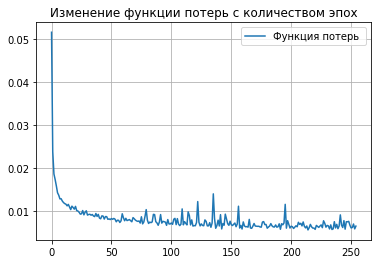

In [ ]:
plt.plot(history.history['loss'], label = 'Функция потерь ')
plt.grid(True)
plt.legend()
plt.title('Изменение функции потерь с количеством эпох', fontsize=12)
plt.show()

Теперь построим модели градиентного бустинга и сохраним все модели на диск.

In [ ]:
Cat = CatBoostClassifier(iterations=1000,
                           learning_rate=0.1,
                           depth=2, verbose=0,)
Cat.fit(X_train, y_train,)

In [ ]:
Cat.save_model('/content/drive/MyDrive/Cat.sav')
print(metrics.classification_report(y_test, Cat.predict(X_test)))
print(metrics.roc_auc_score(y_test, Cat.predict(X_test)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      9711
           1       0.87      0.87      0.87     12833

    accuracy                           0.85     22544
   macro avg       0.85      0.85      0.85     22544
weighted avg       0.85      0.85      0.85     22544

0.8504165777873716


In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/drive/MyDrive/model.h5")

In [ ]:
lgb_train_data = lgb.Dataset(X_train, label=y_train)
model_lgb = lgb.LGBMClassifier(num_boost_round=5000)
model_lgb.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_boost_round=5000, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
lgb_preds = model_lgb.predict(X_test)
filename = '/content/drive/MyDrive/model_lgb.sav'
joblib.dump(model_lgb, filename)
print(metrics.classification_report(y_test, lgb_preds))
print(metrics.roc_auc_score(y_test, lgb_preds))

              precision    recall  f1-score   support

           0       0.73      0.94      0.82      9711
           1       0.94      0.73      0.82     12833

    accuracy                           0.82     22544
   macro avg       0.83      0.83      0.82     22544
weighted avg       0.85      0.82      0.82     22544

0.8348189185018933


Результаты  показывают, что все модели кроме CatBoost склонны слишком часто признавать активность нормальной. Но для нас первичной задачей является не пропустить аномальную активность и определить ее. В то время как, recall для аномалий у CatBoost доходит до 0.82, у других моделей этот показатель находится, примерно, на уровне 0.70. Посмотрим сколько атак было пропущено каждой моделью и составим анасамбль с максимальной нетерпимостью к атакам.

In [ ]:
Cat = CatBoostClassifier()
cat = Cat.load_model('/content/drive/MyDrive/Cat.sav')
cat_preds = cat.predict(X_test)

model_lgb = joblib.load('/content/drive/MyDrive/model_lgb.sav')
lgb_preds = model_lgb.predict(X_test)

json_file = open('/content/drive/MyDrive/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/drive/MyDrive/model.h5")
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
net_preds = loaded_model.predict_classes(X_test)

loaded_rfc = joblib.load('/content/drive/MyDrive/rfc.sav')
rfc_preds = loaded_rfc.predict(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Как мы можем увидеть ниже - нейросеть демонстрирует не самые лучшие показатели по самой значимой метрике, но это от части связано с тем, что она выходном нейроне используется сигмойда определяющая вероятностный исход с границей в 0,5. Это значит, что мы можем понизить порог терпимости к аномалиям, сместив границу класса ближе к нулю:


In [ ]:
net_strict= []
for i in loaded_model.predict(X_test):
  if i > 1e-13:
    net_strict.append(1)
  else:
    net_strict.append(0)
print(metrics.classification_report(y_test, net_strict))
print(metrics.roc_auc_score(y_test, net_strict))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      9711
           1       0.92      0.99      0.95     12833

    accuracy                           0.94     22544
   macro avg       0.95      0.94      0.94     22544
weighted avg       0.95      0.94      0.94     22544

0.9376358430904363


In [ ]:
confusion_df= pd.DataFrame(columns=['Model', 'False Negatives', 'False Positive'])
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, cat_preds)
confusion_df.loc[0] = ['CatBoost', cm[1,0], cm[0,1]]
cm = confusion_matrix(y_test, lgb_preds)
confusion_df.loc[1] = ['LightGBM', cm[1,0], cm[0,1]]
cm = confusion_matrix(y_test, net_preds)
confusion_df.loc[2] = ['Net', cm[1,0], cm[0,1]]
cm = confusion_matrix(y_test, rfc_preds)
confusion_df.loc[3] = ['RFC', cm[1,0], cm[0,1]]
cm = confusion_matrix(y_test, net_strict)
confusion_df.loc[4] = ['net_strict', cm[1,0], cm[0,1]]


confusion_df

,Model,False Negatives,False Positive
0,CatBoost,1705,1615
1,LightGBM,3444,602
2,Net,3959,579
3,RFC,3580,697
4,net_strict,184,1072


Составим ансамбль моделей, без использования смещения в нейросети:

In [ ]:
ansamble = []
for a, b, c, d in zip(cat_preds, lgb_preds, net_strict, rfc_preds):
  sum = a*0.5+b*0.25+d*0.25
  if sum >= 0.25:
    ansamble.append(1)
  else:
    ansamble.append(0)

In [ ]:
print(metrics.classification_report(y_test, ansamble))
print(metrics.roc_auc_score(y_test, ansamble))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      9711
           1       0.87      0.89      0.88     12833

    accuracy                           0.86     22544
   macro avg       0.86      0.85      0.86     22544
weighted avg       0.86      0.86      0.86     22544

0.8549777015179183


Готово! Получен ансамбль, который определяет аномальную активность в 89% случаев и нейросеть в 99% случаев.

Однако, даже комбинация трёх моделей делает ошибки и надо пологать, что некоторые виды атак значительно отличаются своими характеристиками от остальных. Для дальнейших исследований мы можем выделить характеристики, которые связаны с ошибкой и их значения.

In [ ]:
mistake = []
for i, j in zip(y_test, ansamble):
  if i != j:
    mistake.append(1)
  else:
    mistake.append(0)

In [ ]:
encoded_test['mistake'] =  mistake
df_test['mistake'] = mistake

Посмотрим какой процент составляют пропущенные атаки от всех атак для видов аномалий, которые вызвали затруднения у моделей:

In [ ]:
total_miss = df_test['attack'].loc[df_test['mistake'] == 1].value_counts()
total = df_test['attack'].value_counts()
top = []
for i in df_test['attack'].unique():
  try:
    top.append([i, (total_miss[i]/total[i]) * 100])
  except:
    pass
for i in range(len(top)):
  top[i][1] = top[i][1].round()
top = np.array(top)
top = pd.DataFrame(top, columns=['type', 'percent of False'])
top

,type,percent of False
0,normal,18.0
1,guess_passwd,45.0
2,apache2,63.0
3,buffer_overflow,5.0
4,back,51.0
5,warezmaster,20.0
6,processtable,0.0
7,httptunnel,1.0
8,ps,13.0
9,snmpguess,17.0


В полученном списке есть виды атак, которых не было в тренировочной выборке т.е. ансамбль различает даже не столько конкретные атаки, сколько необычную активность. Теперь посмотрим какие значения оказывают наибольшее влияния на шанс ошибки:

In [ ]:
corr_list = []
for i in encoded_test:
  if encoded_test['mistake'].corr(encoded_test[i]) > 0.01 and i!= 'mistake':
   print(i, encoded_test['mistake'].corr(encoded_test[i]))
   corr_list.append(i)
corr_list.append('mistake')

protocoltype 0.32117592407963946
flag 0.158979472093433
srcbytes 0.032563541722271744
wrongfragment 0.08876760375725487
hot 0.043887059157583064
loggedin 0.02168644233165526
isguestlogin 0.030503457416751294
count 0.06136354505642723
srvcount 0.31748429376874976
samesrvrate 0.20199082229674137
dsthostcount 0.16203386019555122
dsthostsrvcount 0.16853563616093098
dsthostsamesrvrate 0.16753390750394484
dsthostsamesrcportrate 0.13595684685324988


И просто для наглядности посмотрим на моду для строк и среднее для чисел по этим характеристикам, просто чтобы увидеть есть ли ощутимая разница:

In [ ]:
miss = df_test.loc[df_test['mistake'] == 1].mode()
trust = df_test.loc[df_test['mistake'] == 0].mode()
df_cor = [[], []]
for i in corr_list[:-1]:
  if type(df_test[i][0]) == type('str'):
    df_cor[0].append(trust[i][0])
    df_cor[1].append(miss[i][0])
  else:
    df_cor[0].append(encoded_test[i].loc[df_test['mistake'] == 0].mean())
    df_cor[1].append(encoded_test[i].loc[df_test['mistake'] == 1].mean())
df_cor[0].append(0)
df_cor[1].append(1)
df_cor = pd.DataFrame(np.array(df_cor))

for i in np.arange(-1, len(corr_list), 1):
  df_cor = df_cor.rename(columns={i:corr_list[i]})
df_cor

,protocoltype,service,flag,dstbytes,wrongfragment,count,srvcount,samesrvrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostsamesrcportrate,mistake
0,tcp,http,SF,1837.8146626404634,0.0031681599920796,73.48349091629127,19.661501905846244,0.7187921390030347,189.686401663284,135.94584426513538,0.5894450769763955,0.1116137814959652,0
1,udp,private,SF,3937.342723004695,0.05377720870678617,126.83525394793,129.95561246265473,0.9261673068715319,229.9346991037132,182.17584293640633,0.7749210413999155,0.3102774221084076,1


На данном этапе заканчивается работа с данными. В результате у нас есть ансамбль предсказывающий аномальную активность и мы знаем с каким данными в дальнейшем можно работать, чтобы повысить точность алгоритмов.